In [1]:
import pandas as pd
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
from numpy import array, ndarray
from pandas import read_csv, DataFrame, Series
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, read_train_test_from_files, plot_multibar_chart, evaluate_approach, HEIGHT, plot_evaluation_results, plot_multiline_chart
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


# Load split dataset

In [2]:
target = "CovidPos"
file_tag = "modeling/pos_covid_evaluation_MLP"
eval_metric = "accuracy"

train: DataFrame = read_csv("datasets/class_pos_covid_train.csv", index_col="Unnamed: 0", na_values=None)
test: DataFrame = read_csv("datasets/class_pos_covid_test.csv", index_col="Unnamed: 0", na_values=None)

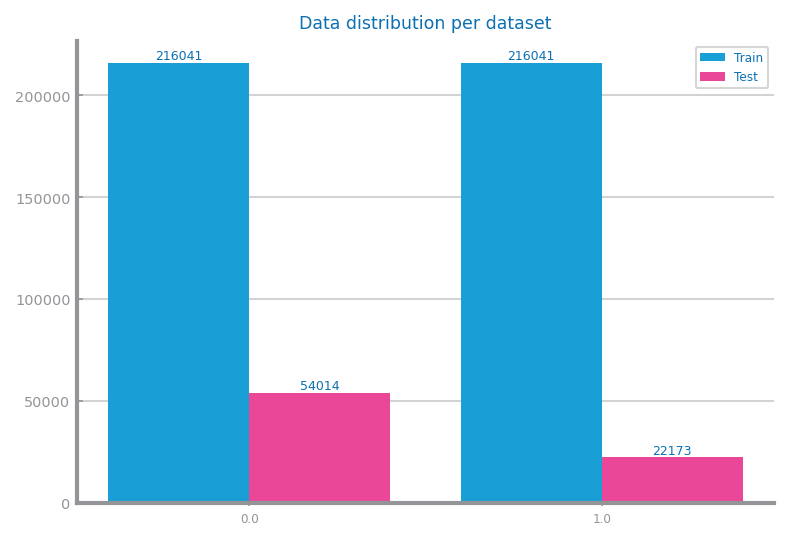

In [3]:
positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {}

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

labels: list = list(train[target].unique())
labels.sort()

plt.figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
plt.show()

# Study

In [4]:
trnX = train.copy(deep=True)
trnY = trnX[target]
trnX = trnX.drop(target, axis=1)

tstX = test.copy(deep=True)
tstY = tstX[target]
tstX = tstX.drop(target, axis=1)

In [5]:
def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = plt.subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

## Default Hyperparams

MLP best for 1000 iterations (lr_type=constant and lr=0.05


<Figure size 600x450 with 0 Axes>

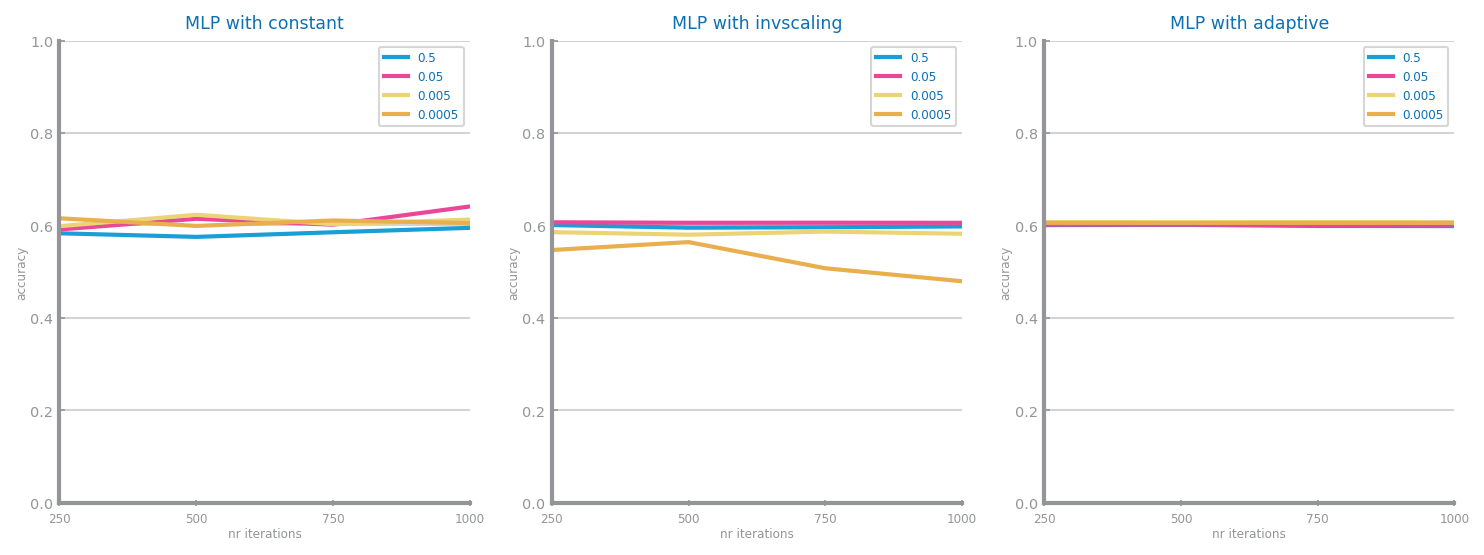

In [6]:
eval_metric = "accuracy"

plt.figure()
best_model_acc_1, params_acc_1 = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=1000,
    lag=250,
    metric=eval_metric,
)
plt.savefig(f"images/{file_tag}_{eval_metric}_study.png")
plt.show()

# Performance Analysis

chosen recall because optimizing with accuracy vs recall doesnt change much, and since this is medical predictions is best to maximize recall score

<Figure size 600x450 with 0 Axes>

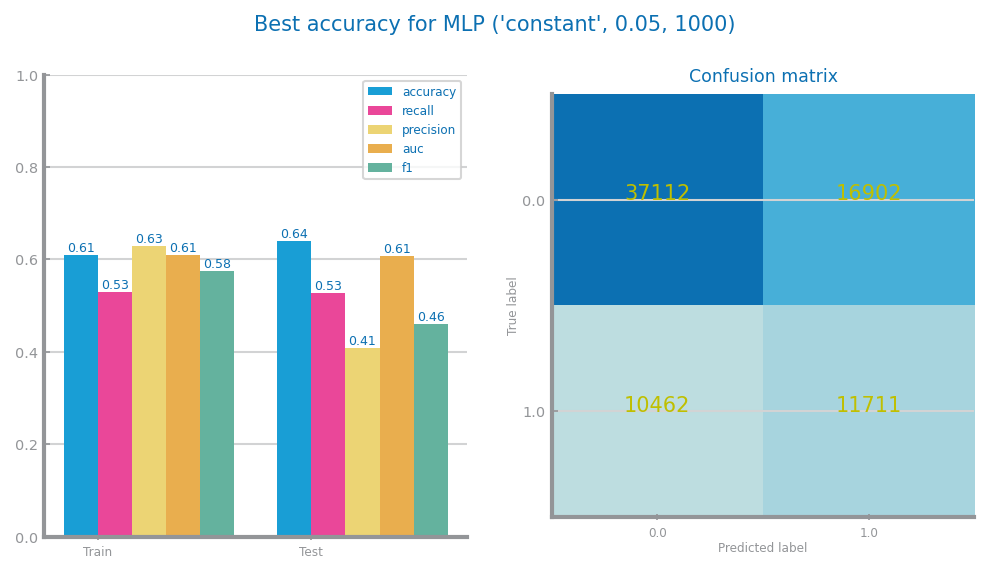

In [10]:
from dslabs_functions import plot_evaluation_results

best_model = best_model_acc_1
best_params = params_acc_1

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
plt.figure()
plot_evaluation_results(best_params, trnY, prd_trn, tstY, prd_tst, labels)
plt.savefig(f'images/{file_tag}_{best_params["name"]}_best_{best_params["metric"]}_eval.png')
plt.show()

# Overfitting Study

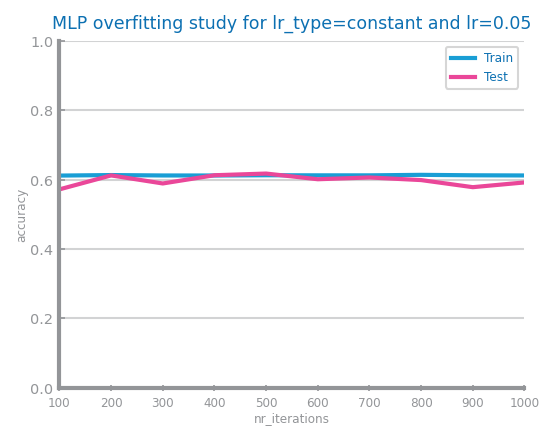

In [8]:
lr_type: Literal["constant", "invscaling", "adaptive"] = best_params["params"][0]
lr: float = best_params["params"][1]
nr_iterations: list[int] = [i for i in range(100, 1001, 100)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

plt.figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
plt.savefig(f"images/{file_tag}_{eval_metric}_overfitting.png")